<h1> Imports </h1>

In [2]:
import os
import shutil
import sys
import json
import traceback
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from info_nce import InfoNCE
from tqdm import tqdm
from collections import OrderedDict
import tqdm as notebook_tqdm

In [3]:
from torchvision.utils import make_grid
from PIL import Image
import kornia
from kornia.augmentation.container import AugmentationSequential
from pytorch_msssim import ssim

import utils
from models import Voxel2StableDiffusionModel
from convnext import ConvnextXL

In [4]:
def set_ddp():
    import torch.distributed as dist
    env_dict = {
        key: os.environ.get(key)
        for key in ("MASTER_ADDR", "MASTER_PORT", "RANK",
                    "LOCAL_RANK", "WORLD_SIZE", "NUM_GPUS")
    }
    rank = int(os.environ["RANK"])
    local_rank = int(os.environ["LOCAL_RANK"])
    n = int(os.environ.get("NUM_GPUS", 8))
    device_ids = list(
        range(local_rank * n, (local_rank + 1) * n)
    )

    if local_rank == 0:
        print(f"[{os.getpid()}] Initializing process group with: {env_dict}")
    dist.init_process_group(backend="nccl")
    print(
        f"[{os.getpid()}] world_size = {dist.get_world_size()}, "
        + f"rank = {dist.get_rank()}, backend={dist.get_backend()}"
    )

    print(
        f"[{os.getpid()}] rank = {dist.get_rank()} ({rank}), "
        + f"world_size = {dist.get_world_size()}, n = {n}, device_ids = {device_ids}"
    )
    device = torch.device("cuda", local_rank)
    return local_rank, device, n

In [5]:
local_rank = 0
device = torch.device("cuda:0")
num_devices = 1
distributed = False

In [6]:
from diffusers.models import AutoencoderKL
autoenc = AutoencoderKL(
    down_block_types=['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'],
    up_block_types=['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'],
    block_out_channels=[128, 256, 512, 512],
    layers_per_block=2,
    sample_size=256
)
autoenc.load_state_dict(torch.load('../train_logs/models/sd_image_var_autoenc.pth'))
autoenc.requires_grad_(False)
autoenc.eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
          (1): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3,

<h1> Configurations </h1>

In [8]:
model_name = "autoencoder"
modality = "image" # ("image", "text")
image_var = 'images' if modality=='image' else None  # trial
clamp_embs = False # clamp embeddings to (-1.5, 1.5)

voxel_dims = 1 # 1 for flattened;  3 for 3d
n_samples_save = 4 # how many SD samples from train and val to save

use_reconst = False
batch_size = 8
num_epochs = 120
lr_scheduler = 'cycle'
initial_lr = 1e-3
max_lr = 5e-4
first_batch = False
ckpt_saving = True
ckpt_interval = 24
save_at_end = False
use_mp = False
remote_data = False
data_commit = "avg"  # '9947586218b6b7c8cab804009ddca5045249a38d'
mixup_pct = -1
use_cont = True
use_sobel_loss = False
use_blurred_training = False

use_full_trainset = True
subj_id = "01"
seed = 0
# ckpt_path = "../train_logs/models/autoencoder_final/test/ckpt-epoch015.pth"
ckpt_path1 = "../train_logs/autoencoder_subj01_4x_locont_no_reconst/epoch120.pth"
ckpt_path = None
cont_model = 'cnx'
resume_from_ckpt = False
ups_mode = '4x'

In [9]:
# need non-deterministic CuDNN for conv3D to work
utils.seed_everything(seed+local_rank, cudnn_deterministic=False)
torch.backends.cuda.matmul.allow_tf32 = True

# if running command line, read in args or config file values and override above params
try:
    config_keys = [k for k,v in globals().items() if not k.startswith('_') \
                   and isinstance(v, (int, float, bool, str))]
    exec(open('configurator.py').read()) # overrides from command line or config file
    config = {k: globals()[k] for k in config_keys} # will be useful for logging
except:
    pass

Note: not using cudnn.deterministic


In [ ]:
if distributed:
    local_rank, device, num_devices = set_ddp()
autoenc
# .to(device)

In [11]:
if use_cont:
    mixup_pct = -1
    if cont_model == 'cnx':
        cnx = ConvnextXL('../train_logs/models/convnext_xlarge_alpha0.75_fullckpt.pth')
        cnx.requires_grad_(False)
        cnx.eval()
        cnx
        #.to(device)
    train_augs = AugmentationSequential(
        # kornia.augmentation.RandomCrop((480, 480), p=0.3),
        # kornia.augmentation.Resize((512, 512)),
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.8),
        kornia.augmentation.RandomGrayscale(p=0.2),
        kornia.augmentation.RandomSolarize(p=0.2),
        kornia.augmentation.RandomGaussianBlur(kernel_size=(7, 7), sigma=(0.1, 2.0), p=0.1),
        kornia.augmentation.RandomResizedCrop((512, 512), scale=(0.5, 1.0)),
        data_keys=["input"],
    )

outdir = f'../train_logs/models/{model_name}/'
if local_rank==0:
    os.makedirs(outdir, exist_ok=True)


<h2> auto resume </h2>

In [12]:
if os.path.exists(os.path.join(outdir, 'last.pth')):
    ckpt_path = os.path.join(outdir, 'last.pth')
    resume_from_ckpt = True

In [13]:
if num_devices==0: num_devices = 1
num_workers = num_devices

cache_dir = 'cache'
n_cache_recs = 0

<h1> Prep models and data loaders </h1>

In [14]:
if local_rank == 0: print('Creating voxel2sd...')

Creating voxel2sd...


In [15]:
in_dims = {'01': 15724, '02': 14278, '05': 13039, '07':12682}
if voxel_dims == 1: # 1D data
    voxel2sd = Voxel2StableDiffusionModel(use_cont=use_cont, in_dim=in_dims[subj_id], ups_mode=ups_mode)
elif voxel_dims == 3: # 3D data
    raise NotImplementedError()

In [16]:
voxel2sd
#.to(device)
voxel2sd = torch.nn.SyncBatchNorm.convert_sync_batchnorm(voxel2sd)
if distributed:
    voxel2sd = DDP(voxel2sd)

try:
    utils.count_params(voxel2sd)
except:
    if local_rank == 0: print('Cannot count params for voxel2sd (probably because it has Lazy layers)')

param counts:
206,065,604 total
206,065,604 trainable


In [17]:
if local_rank == 0: print('Pulling NSD webdataset data...')

# train_url = f"{{/fsx/proj-fmri/shared/natural-scenes-dataset/webdataset_avg_split/train/train_subj{subj_id}_{{0..17}}.tar,/fsx/proj-fmri/shared/natural-scenes-dataset/webdataset_avg_split/val/val_subj{subj_id}_0.tar}}"
# val_url = f"/fsx/proj-fmri/shared/natural-scenes-dataset/webdataset_avg_split/test/test_subj{subj_id}_{{0..1}}.tar"
# meta_url = f"/fsx/proj-fmri/shared/natural-scenes-dataset/webdataset_avg_split/metadata_subj{subj_id}.json"

train_url = f"../data/train_subj01_"+"{0..2}.tar"
val_url = f"../data/val_subj01_0.tar"
meta_url = f"../data/metadata_subj01.json"

Pulling NSD webdataset data...


In [18]:
if local_rank == 0: print('Prepping train and validation dataloaders...')
num_train = 8559 + 300
num_val = 982

Prepping train and validation dataloaders...


In [19]:
train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
    batch_size,
    num_devices=num_devices,
    num_workers=num_workers,
    train_url=train_url,
    val_url=val_url,
    meta_url=meta_url,
    val_batch_size=max(16, batch_size),
    cache_dir='/tmp/wds-cache',
    seed=seed+local_rank,
    voxels_key='nsdgeneral.npy',
    local_rank=local_rank,
    num_train=num_train,
    num_val=num_val
)

Getting dataloaders...

num_train 8859
global_batch_size 8


batch_size 8
num_workers 1
num_batches 1107
num_worker_batches 1107

num_val 982
val_num_batches 122
val_batch_size 16


In [20]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
opt_grouped_parameters = [
    {'params': [p for n, p in voxel2sd.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in voxel2sd.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [21]:
optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, 
                                            total_steps=num_epochs*((num_train//batch_size)//num_devices), 
                                            final_div_factor=1000,
                                            last_epoch=-1, pct_start=2/num_epochs)
    

In [22]:
def save_ckpt(tag):
    ckpt_path = os.path.join(outdir, f'{tag}.pth')
    if tag == "last":
        if os.path.exists(ckpt_path):
            shutil.copyfile(ckpt_path, os.path.join(outdir, f'{tag}_old.pth'))
    print(f'saving {ckpt_path}')
    if local_rank==0:
        state_dict = voxel2sd.state_dict()
        for key in list(state_dict.keys()):
            if 'module.' in key:
                state_dict[key.replace('module.', '')] = state_dict[key]
                del state_dict[key]
        try:
            torch.save({
                'epoch': epoch,
                'model_state_dict': state_dict,
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': losses,
                'val_losses': val_losses,
                'lrs': lrs,
                }, ckpt_path)
        except:
            print('Failed to save weights')
            print(traceback.format_exc())
    if tag == "last":
        if os.path.exists(os.path.join(outdir, f'{tag}_old.pth')):
            os.remove(os.path.join(outdir, f'{tag}_old.pth'))

        # if wandb_log:
        #     wandb.save(ckpt_path)

<h2> Optionally resume from checkpoint </h2>

In [23]:
if resume_from_ckpt:
    print("\n---resuming from ckpt_path---\n", ckpt_path)
    checkpoint = torch.load(ckpt_path, map_location=device)
    epoch = checkpoint['epoch']+1
    optimizer.load_state_dict(checkpoint['optimizer_state_dict']) 
    if hasattr(voxel2sd, 'module'):
        voxel2sd.module.load_state_dict(checkpoint['model_state_dict'])
    else:
        voxel2sd.load_state_dict(checkpoint['model_state_dict'])
    total_steps_done = epoch*((num_train//batch_size)//num_devices)
    for _ in range(total_steps_done):
        lr_scheduler.step()
    del checkpoint
    torch.cuda.empty_cache()
else:
    epoch = 0

if local_rank==0: print("\nDone with model preparations!")


Done with model preparations!


<h1> Model? </h1>

In [24]:
progress_bar = tqdm(range(epoch, num_epochs), ncols=150, disable=(local_rank!=0))
losses = []
val_losses = []
lrs = []
best_val_loss = 1e10
best_ssim = 0
# mean = torch.tensor([0.485, 0.456, 0.406]).to(device).reshape(1,3,1,1)
# std = torch.tensor([0.228, 0.224, 0.225]).to(device).reshape(1,3,1,1)
mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1,3,1,1)
std = torch.tensor([0.228, 0.224, 0.225]).reshape(1,3,1,1)
epoch = 0

  0%|                                                                                                                         | 0/120 [00:00<?, ?it/s]

In [25]:
if ckpt_path is not None:
    print("\n---resuming from ckpt_path---\n",ckpt_path)
    checkpoint = torch.load(ckpt_path, map_location=device)
    epoch = checkpoint['epoch']+1
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])        
    voxel2sd.module.load_state_dict(checkpoint['model_state_dict'])
    global_batch_size = batch_size * num_devices
    total_steps_done = epoch*(num_train//global_batch_size)
    for _ in range(total_steps_done):
        lr_scheduler.step()
    del checkpoint
    torch.cuda.empty_cache()

In [26]:
progress_bar = tqdm(range(epoch, num_epochs), ncols=150, disable=(local_rank!=0))


  0%|                                                                                                                         | 0/120 [00:05<?, ?it/s]


In [27]:
from controlnet_aux.midas import MidasDetector 
midas_depth = MidasDetector.from_pretrained(
  "valhalla/t2iadapter-aux-models", filename="dpt_large_384.pt", model_type="dpt_large"
)

c:\Users\lenovo\miniconda3\envs\mindeye\lib\site-packages\controlnet_aux\mediapipe_face\mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [50]:
from torchvision.transforms import transforms

In [56]:
for train_i, (voxel, image, _) in enumerate(val_dl):
    print(type(image), image[0].reshape((256, 256, 3)).shape)
    image = image[0].reshape((256, 256, 3))
    # image_512 = F.interpolate(image, (512, 512), mode='bilinear', align_corners=False, antialias=True)
    # print(type(image_512), image_512.shape)
    test = transforms.ToPILImage()(image[0])
    image_depth = midas_depth(test, detect_resolution=256, image_resolution=512)
    print(type(image_depth))
    # print(train_i)
    # print(type(image_depth), image_depth.size)
    break
print(image)

Image.fromarray(image_depth)

<class 'torch.Tensor'> torch.Size([256, 256, 3])


RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 30485160000 bytes.

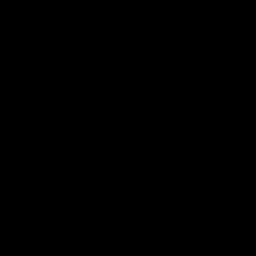

In [49]:
Image.fromarray(image.numpy().astype(np.uint8))

In [32]:
for epoch in progress_bar:
    voxel2sd.train()
    
    loss_mse_sum = 0
    loss_reconst_sum = 0
    loss_cont_sum = 0
    loss_sobel_sum = 0
    val_loss_mse_sum = 0
    val_loss_reconst_sum = 0
    val_ssim_score_sum = 0

    reconst_fails = []

    for train_i, (voxel, image, _) in enumerate(train_dl):
        optimizer.zero_grad()

        # image = image.to(device).float()
        image = image.float()
        image_512 = F.interpolate(image, (512, 512), mode='bilinear', align_corners=False, antialias=True)
        image_depth = midas_depth(image, detect_resolution=512, image_resolution=512)
        voxel = voxel.to(device).float()
        voxel = utils.voxel_select(voxel)
        if epoch <= mixup_pct * num_epochs:
            voxel, perm, betas, select = utils.mixco(voxel)
        else:
            select = None

        with torch.cuda.amp.autocast(enabled=use_mp):
            autoenc_image = kornia.filters.median_blur(image_depth, (15, 15)) if use_blurred_training else image_depth
            image_enc = autoenc.encode(2*autoenc_image-1).latent_dist.mode() * 0.18215
            if use_cont:
                image_enc_pred, transformer_feats = voxel2sd(voxel, return_transformer_feats=True)
            else:
                image_enc_pred = voxel2sd(voxel)
            
            if epoch <= mixup_pct * num_epochs:
                image_enc_shuf = image_enc[perm]
                betas_shape = [-1] + [1]*(len(image_enc.shape)-1)
                image_enc[select] = image_enc[select] * betas[select].reshape(*betas_shape) + \
                    image_enc_shuf[select] * (1 - betas[select]).reshape(*betas_shape)
            
            if use_cont:
                image_norm = (image_512 - mean)/std
                image_aug = (train_augs(image_512) - mean)/std
                _, cnx_embeds = cnx(image_norm)
                _, cnx_aug_embeds = cnx(image_aug)

                cont_loss = utils.soft_cont_loss(
                    F.normalize(transformer_feats.reshape(-1, transformer_feats.shape[-1]), dim=-1),
                    F.normalize(cnx_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    F.normalize(cnx_aug_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    temp=0.075,
                    distributed=distributed
                )
                del image_aug, cnx_embeds, transformer_feats
            else:
                cont_loss = torch.tensor(0)

            # mse_loss = F.mse_loss(image_enc_pred, image_enc)/0.18215
            mse_loss = F.l1_loss(image_enc_pred, image_enc)
            del image_depth, voxel

            if use_reconst: #epoch >= 0.1 * num_epochs:
                # decode only non-mixed images
                if select is not None:
                    selected_inds = torch.where(~select)[0]
                    reconst_select = selected_inds[torch.randperm(len(selected_inds))][:4] 
                else:
                    reconst_select = torch.arange(len(image_enc_pred))
                image_enc_pred = F.interpolate(image_enc_pred[reconst_select], scale_factor=0.5, mode='bilinear', align_corners=False)
                reconst = autoenc.decode(image_enc_pred/0.18215).sample
                # reconst_loss = F.mse_loss(reconst, 2*image[reconst_select]-1)
                reconst_image = kornia.filters.median_blur(image[reconst_select], (7, 7)) if use_blurred_training else image[reconst_select]
                reconst_loss = F.l1_loss(reconst, 2*reconst_image-1)
                if reconst_loss != reconst_loss:
                    reconst_loss = torch.tensor(0)
                    reconst_fails.append(train_i) 
                if use_sobel_loss:
                    sobel_targ = kornia.filters.sobel(kornia.filters.median_blur(image[reconst_select], (3,3)))
                    sobel_pred = kornia.filters.sobel(reconst/2 + 0.5)
                    sobel_loss = F.l1_loss(sobel_pred, sobel_targ)
                else:
                    sobel_loss = torch.tensor(0)
            else:
                reconst_loss = torch.tensor(0)
                sobel_loss = torch.tensor(0)
            

            loss = mse_loss/0.18215 + 2*reconst_loss + 0.1*cont_loss + 16*sobel_loss
            # utils.check_loss(loss)

            loss_mse_sum += mse_loss.item()
            loss_reconst_sum += reconst_loss.item()
            loss_cont_sum += cont_loss.item()
            loss_sobel_sum += sobel_loss.item()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            if local_rank==0:
                logs = OrderedDict(
                    train_loss=np.mean(losses[-(train_i+1):]),
                    val_loss=np.nan,
                    lr=lrs[-1],
                )
                progress_bar.set_postfix(**logs)
        
        loss.backward()
        # if reconst_loss > 0:
        #     torch.nn.utils.clip_grad_norm_(voxel2sd.parameters(), 1.0)
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

    if local_rank==0: 
        voxel2sd.eval()
        for val_i, (voxel, image, _) in enumerate(val_dl): 
            with torch.inference_mode():
                image = image.to(device).float()
                #image = F.interpolate(image, (512, 512), mode='bilinear', align_corners=False, antialias=True)       
                image = midas_depth(image, detect_resolution=512, image_resolution=512)       
                voxel = voxel.to(device).float()
                voxel = voxel.mean(1)
                
                with torch.cuda.amp.autocast(enabled=use_mp):
                    image_enc = autoenc.encode(2*image-1).latent_dist.mode() * 0.18215
                    if hasattr(voxel2sd, 'module'):
                        image_enc_pred = voxel2sd.module(voxel)
                    else:
                        image_enc_pred = voxel2sd(voxel)

                    mse_loss = F.mse_loss(image_enc_pred, image_enc)
                    
                    if use_reconst:
                        reconst = autoenc.decode(image_enc_pred[-16:]/0.18215).sample
                        image = image[-16:]
                        reconst_loss = F.mse_loss(reconst, 2*image-1)
                        ssim_score = ssim((reconst/2 + 0.5).clamp(0,1), image, data_range=1, size_average=True, nonnegative_ssim=True)
                    else:
                        reconst = None
                        reconst_loss = torch.tensor(0)
                        ssim_score = torch.tensor(0)

                    val_loss_mse_sum += mse_loss.item()
                    val_loss_reconst_sum += reconst_loss.item()
                    val_ssim_score_sum += ssim_score.item()

                    val_losses.append(mse_loss.item() + reconst_loss.item())        

            logs = OrderedDict(
                train_loss=np.mean(losses[-(train_i+1):]),
                val_loss=np.mean(val_losses[-(val_i+1):]),
                lr=lrs[-1],
            )
            progress_bar.set_postfix(**logs)

        if (not save_at_end and ckpt_saving) or (save_at_end and epoch == num_epochs - 1):
            # save best model
            val_loss = np.mean(val_losses[-(val_i+1):])
            val_ssim = val_ssim_score_sum / (val_i + 1)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                save_ckpt('best')
            else:
                print(f'not best - val_loss: {val_loss:.3f}, best_val_loss: {best_val_loss:.3f}')
            if val_ssim > best_ssim:
                best_ssim = val_ssim
                save_ckpt('best_ssim')
            else:
                print(f'not best - val_ssim: {val_ssim:.3f}, best_ssim: {best_ssim:.3f}')

            save_ckpt('last')
            # Save model checkpoint every `ckpt_interval`` epochs or on the last epoch
            if (ckpt_interval is not None and (epoch + 1) % ckpt_interval == 0) or epoch == num_epochs - 1:
                save_ckpt(f'epoch{(epoch+1):03d}')
            try:
                orig = image
                if reconst is None:
                    reconst = autoenc.decode(image_enc_pred[-16:].detach()/0.18215).sample
                    orig = image[-16:]
                pred_grid = make_grid(((reconst/2 + 0.5).clamp(0,1)*255).byte(), nrow=int(len(reconst)**0.5)).permute(1,2,0).cpu().numpy()
                orig_grid = make_grid((orig*255).byte(), nrow=int(len(orig)**0.5)).permute(1,2,0).cpu().numpy()
                comb_grid = np.concatenate([orig_grid, pred_grid], axis=1)
                del pred_grid, orig_grid
                Image.fromarray(comb_grid).save(f'{outdir}/reconst_epoch{(epoch+1):03d}.png')
            except:
                print("Failed to save reconst image")
                print(traceback.format_exc())

        logs = {
            "train/loss": np.mean(losses[-(train_i+1):]),
            "val/loss": np.mean(val_losses[-(val_i+1):]),
            "train/lr": lrs[-1],
            "train/num_steps": len(losses),
            "train/loss_mse": loss_mse_sum / (train_i + 1),
            "train/loss_reconst": loss_reconst_sum / (train_i + 1),
            "train/loss_cont": loss_cont_sum / (train_i + 1),
            "train/loss_sobel": loss_sobel_sum / (train_i + 1),
            "val/loss_mse": val_loss_mse_sum / (val_i + 1),
            "val/loss_reconst": val_loss_reconst_sum / (val_i + 1),
            "val/ssim": val_ssim_score_sum / (val_i + 1),
        }
        if local_rank==0: print(logs)
        if len(reconst_fails) > 0 and local_rank==0:
            print(f'Reconst fails {len(reconst_fails)}/{train_i}: {reconst_fails}')

    if distributed:
        dist.barrier()


AssertionError: 